# Best location to setup a cafe in Vietnam city

## Import all necessary packages

In [25]:
!pip install folium
import pandas as pd
import numpy as np

# convert an address into latitude and longitude values
from geopy import geocoders
from geopy.geocoders import Nominatim

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize  

# Scrape the web to get the data
from bs4 import BeautifulSoup
import requests

import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# find the distances
from scipy.spatial.distance import cdist

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# translate Vietnamese character (with accents) 
#     to the closest possible representation in ascii text
!pip install unidecode
from unidecode import unidecode

### Collecting data

We don't have an all-in-one talbe, we have to collect all necessary information from various data tables.

First, we scrape the list of all 19 urban districts from a list of administrative units on a wiki page of Ho Chi Minh City.

In [2]:
source_wiki_hcm = requests.get("https://en.wikipedia.org/wiki/Ho_Chi_Minh_City").text
soup = BeautifulSoup(source_wiki_hcm, 'lxml')
table_wiki_hcm = ( soup.find("span", {"id": "Demographics"})
                    .parent.previous_sibling.previous_sibling )

table_rows = table_wiki_hcm.tbody.find_all("tr")
res_hcm = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    res_hcm.append(row)
 

In [3]:
 df_hcm = pd.DataFrame(res_hcm, columns=["District", "Subdistrict", 
                        "Area (km2)", "", "", "", "", "Population 2015", ""])
df_hcm.drop("", axis=1, inplace=True)
df_hcm = df_hcm.iloc[3:22].reset_index().drop("index", axis=1)
df_hcm["Population 2015"] = (
                            df_hcm["Population 2015"].str.replace("\n", "")
                                .str.replace(",", "")
                                .str.replace(".", "")
                                .str.strip()
                            )
# Add the "Density" column = Population / Area
df_hcm["Density (pop/m2)"] = round(df_hcm["Population 2015"].astype(float) 
                                       / df_hcm["Area (km2)"].astype(float)
                                   , 3)
# remove the word "District"
df_hcm["District"] = ( df_hcm["District"]
                              .str.replace("District", "")
                              .str.strip()
                         )
# remove Vietnamese accents
df_hcm["District"] = df_hcm["District"].apply(unidecode)
df_hcm

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2)
0,1,10 wards,7.73,193632,25049.418
1,2,11 wards,49.74,147168,2958.745
2,3,14 wards,4.92,196333,39905.081
3,4,15 wards,4.18,186727,44671.531
4,5,15 wards,4.27,178615,41830.211
5,6,14 wards,7.19,258945,36014.604
6,7,10 wards,35.69,310178,8690.894
7,8,16 wards,19.18,431969,22521.846
8,9,13 wards,114,290620,2549.298
9,10,15 wards,5.72,238558,41705.944


### Housing price

Next, we collect the housing price at different districts of HCMC.

In [4]:
source_housing_price = requests.get("https://mogi.vn/gia-nha-dat").text
soup = BeautifulSoup(source_housing_price, 'lxml')
table_housing_price = soup.find("div", class_="mt-table")

In [5]:
table_rows = table_housing_price.find_all("div", class_="mt-row")
res_housing_price = []
for tr in table_rows:
    district = tr.find("div", class_="mt-street").a.text
    medium_price = tr.find("div", class_="mt-vol").span.text
    row = [district, medium_price]
    res_housing_price.append(row)

In [6]:
df_housing_price = pd.DataFrame(res_housing_price, 
                                columns=["District", "Average Housing Price (1M VND)"])
df_housing_price = df_housing_price.iloc[:19].reset_index().drop("index", axis=1)

# Remove the word "Quận"
df_housing_price["District"] = ( df_housing_price["District"]
                                        .str.replace("\n", "").str.replace("Quận", "")
                                        .str.strip() 
                                   )

# Remove Vietnamese accents
df_housing_price["District"] = df_housing_price["District"].apply(unidecode)

# Remove the word "triệu" (It's 10^6 in Vietnamese)
df_housing_price["Average Housing Price (1M VND)"] = ( df_housing_price["Average Housing Price (1M VND)"]
                                                .str.replace("triệu", "")
                                                 .str.replace(",", ".")
                                                 .str.strip()
                                            )
df_housing_price

,District,Average Housing Price (1M VND)
0,1,430 /m2
1,2,81.2 /m2
2,3,272 /m2
3,4,85.7 /m2
4,5,255 /m2
5,6,115 /m2
6,7,86.4 /m2
7,8,67 /m2
8,9,48.2 /m2
9,10,213 /m2


### Merge two dataframes df_hcm and df_housing_price into one table called df

In [7]:
df = pd.merge(df_hcm, df_housing_price, how='left', left_on = 'District', right_on = 'District')
df

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2),Average Housing Price (1M VND)
0,1,10 wards,7.73,193632,25049.418,430 /m2
1,2,11 wards,49.74,147168,2958.745,81.2 /m2
2,3,14 wards,4.92,196333,39905.081,272 /m2
3,4,15 wards,4.18,186727,44671.531,85.7 /m2
4,5,15 wards,4.27,178615,41830.211,255 /m2
5,6,14 wards,7.19,258945,36014.604,115 /m2
6,7,10 wards,35.69,310178,8690.894,86.4 /m2
7,8,16 wards,19.18,431969,22521.846,67 /m2
8,9,13 wards,114,290620,2549.298,48.2 /m2
9,10,15 wards,5.72,238558,41705.944,213 /m2


### Get the coordinates of the districts

Next, we find all coordinates of all urban districts in HCMC their name. In order to do that, we create a function which does the same job for all.

In [33]:
def find_coor(name):
    address = name + " Ho Chi Minh City Vietnam"
    geolocator = Nominatim(user_agent="hcmc")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return [latitude, longitude]

In [34]:
# For District 1 to 12 (numbers)
coords = [find_coor("District " + dist) for dist in df["District"].iloc[:12].tolist()]

# For the other districts (letters)
coords = coords + [find_coor(dist + " District") for dist in df["District"].iloc[12:].tolist()]

df_coords = pd.DataFrame(coords, columns=["Latitude", "Longitude"])

df["Latitude"] = df_coords["Latitude"]
df["Longitude"] = df_coords["Longitude"]

df

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2),Average Housing Price (1M VND),Latitude,Longitude
0,1,10 wards,7.73,193632,25049.418,430 /m2,10.774540,106.699184
1,2,11 wards,49.74,147168,2958.745,81.2 /m2,10.791116,106.736729
2,3,14 wards,4.92,196333,39905.081,272 /m2,10.783529,106.687098
3,4,15 wards,4.18,186727,44671.531,85.7 /m2,10.759243,106.704890
4,5,15 wards,4.27,178615,41830.211,255 /m2,10.756129,106.670376
5,6,14 wards,7.19,258945,36014.604,115 /m2,10.746928,106.634495
6,7,10 wards,35.69,310178,8690.894,86.4 /m2,10.736573,106.722432
7,8,16 wards,19.18,431969,22521.846,67 /m2,10.740400,106.665843
8,9,13 wards,114,290620,2549.298,48.2 /m2,10.824543,106.818015
9,10,15 wards,5.72,238558,41705.944,213 /m2,10.773198,106.667833


## Plot the maps

### HCMC map

First, we get the coordinate of Ho Chi Minh City and plot its map.

In [35]:
[hcm_lat, hcm_long] = find_coor("")
print('The geograpical coordinate of Ho Chi Minh City are {}, {}.'.format(hcm_lat, hcm_long))

The geograpical coordinate of Ho Chi Minh City are 10.6497452, 106.76197937344351.


In [36]:
map_hcm = folium.Map(location=[hcm_lat, hcm_long], zoom_start=11)
for lat, lng, dis in zip(df['Latitude'], df['Longitude'], df['District']):
    label = '{}'.format(dis)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hcm)  

map_hcm

### Define Foursquare Credentials and Version


On the public repository on Github, I remove this field for the privacy!

In [37]:
CLIENT_ID = 'POLHESRKW3XHK2RRL43QDI0MTY1IMDPIQYRHVYKTHVQBOAWZ'
CLIENT_SECRET = 'MQEW54YAQYCNSE2C3RMF04TGMUZASA21XCCTE4LVEC3DBJT5'
VERSION = '20180605'

### Explore the venues of urbant districts

First, let's create a function to repeat the same process to all the districts of HCMC

In [38]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500, LIMIT=150):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
hcm_venues = getNearbyVenues(names=df['District'],
                             latitudes=df['Latitude'],
                             longitudes=df['Longitude']
                            )

In [40]:
hcm_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,10.77454,106.699184,Pizza 4P's,10.773301,106.697599,Pizza Place
1,1,10.77454,106.699184,Pasteur Street Brewing Company,10.775220,106.700894,Brewery
2,1,10.77454,106.699184,Bep Me In,10.773810,106.698152,Vietnamese Restaurant
3,1,10.77454,106.699184,Liberty Central Saigon Citypoint Hotel,10.774758,106.700795,Hotel
4,1,10.77454,106.699184,Takashimaya,10.773194,106.701075,Department Store


Let's check how many venues were returned for each district.

In [41]:
hcm_venues_group = hcm_venues.groupby('District').count().reset_index()
hcm_venues_group

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,100,100,100,100,100,100
1,10,100,100,100,100,100,100
2,11,35,35,35,35,35,35
3,12,9,9,9,9,9,9
4,2,57,57,57,57,57,57
5,3,100,100,100,100,100,100
6,4,70,70,70,70,70,70
7,5,100,100,100,100,100,100
8,6,18,18,18,18,18,18
9,7,59,59,59,59,59,59


In [42]:
print('In above table, there are {} uniques categories.'.format(len(hcm_venues['Venue Category'].unique())))

In above table, there are 131 uniques categories.


## Results

### The list of unique categories

The list of first 50 categories.

In [43]:
hcm_venues['Venue Category'].unique()[:50]

array(['Pizza Place', 'Brewery', 'Vietnamese Restaurant', 'Hotel',
       'Department Store', 'Spanish Restaurant', 'Jazz Club', 'Multiplex',
       'Supermarket', 'Steakhouse', 'Café', 'Speakeasy', 'Massage Studio',
       'Clothing Store', 'Coffee Shop', 'Dessert Shop',
       'Italian Restaurant', 'Whisky Bar', 'Restaurant',
       'Asian Restaurant', 'Food Court', 'Tapas Restaurant',
       'Thai Restaurant', 'Burger Joint', 'German Restaurant', 'Bar',
       'Bookstore', 'Soup Place', 'Museum', 'Jewelry Store', 'Nightclub',
       'Opera House', 'Vegetarian / Vegan Restaurant', 'Hotel Bar',
       'Cupcake Shop', 'French Restaurant', 'Noodle House',
       'Mexican Restaurant', 'Spa', 'North Indian Restaurant',
       'Middle Eastern Restaurant', 'Cocktail Bar', 'Indian Restaurant',
       'Sandwich Place', 'Park', 'Hotpot Restaurant',
       'Japanese Restaurant', 'Bakery', 'Shoe Store', 'BBQ Joint'],
      dtype=object)

### Number of venues in each district

We plot a chart in order to compare visually the different of number of venues between districts.

Text(0, 0.5, 'Number of venues')

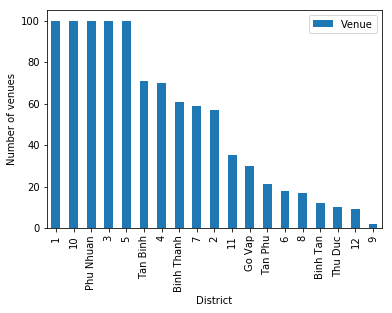

In [44]:
ax = hcm_venues_group.sort_values(by="Venue", ascending=False).plot(x="District", y="Venue", kind="bar")
ax.set_ylabel("Number of venues")

### The number of venues in each category.

In [45]:
most_venues = hcm_venues.groupby('Venue Category').count().sort_values(by="Venue", ascending=False)
most_venues.head(15)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Vietnamese Restaurant,135,135,135,135,135,135
Café,126,126,126,126,126,126
Coffee Shop,76,76,76,76,76,76
Seafood Restaurant,38,38,38,38,38,38
Hotel,29,29,29,29,29,29
Chinese Restaurant,29,29,29,29,29,29
Vegetarian / Vegan Restaurant,24,24,24,24,24,24
Asian Restaurant,19,19,19,19,19,19
Multiplex,17,17,17,17,17,17


### The number of categories in each district

Text(0, 0.5, 'Number of categories')

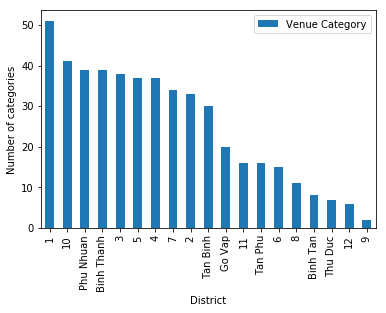

In [47]:
hcm_venues_group_cat = (
    hcm_venues.groupby(['District','Venue Category'])
        .count().reset_index()[['District', 'Venue Category']]
            .groupby('District').count().reset_index()
)
# hcm_venues_group_cat
ax = hcm_venues_group_cat.sort_values(by="Venue Category", ascending=False).plot(x="District", y="Venue Category", kind="bar")
ax.set_ylabel("Number of categories")

### Top 10 venue categories for each district

In [48]:
# one hot encoding
hcm_onehot = pd.get_dummies(hcm_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
hcm_onehot['District'] = hcm_venues['District'] 

# move district column to the first column
fixed_columns = [hcm_onehot.columns[-1]] + list(hcm_onehot.columns[:-1])
hcm_onehot = hcm_onehot[fixed_columns]

# group the rows by district and by taking the mean of the frequency of occurrence of each category
hcm_grouped = hcm_onehot.groupby('District').mean().reset_index()
hcm_grouped.head()

,District,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,...,Theater,Theme Park,Travel Agency,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Yoga Studio
0,1,0.0,0.0,0.00,0.010000,0.0,0.0,0.000000,0.010000,0.0,...,0.00,0.000000,0.0,0.000000,0.020000,0.120000,0.0,0.000000,0.01,0.0
1,10,0.0,0.0,0.01,0.020000,0.0,0.0,0.000000,0.010000,0.0,...,0.01,0.000000,0.0,0.000000,0.020000,0.190000,0.0,0.000000,0.00,0.0
2,11,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.00,0.028571,0.0,0.000000,0.028571,0.085714,0.0,0.028571,0.00,0.0
3,12,0.0,0.0,0.00,0.000000,0.0,0.0,0.111111,0.000000,0.0,...,0.00,0.000000,0.0,0.000000,0.000000,0.222222,0.0,0.000000,0.00,0.0
4,2,0.0,0.0,0.00,0.017544,0.0,0.0,0.000000,0.052632,0.0,...,0.00,0.000000,0.0,0.017544,0.000000,0.157895,0.0,0.000000,0.00,0.0


In [49]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hcm_10 = pd.DataFrame(columns=columns)
hcm_10['District'] = hcm_grouped['District']

for ind in np.arange(hcm_grouped.shape[0]):
    hcm_10.iloc[ind, 1:] = return_most_common_venues(hcm_grouped.iloc[ind, :], num_top_venues)

hcm_10

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Vietnamese Restaurant,Hotel,Coffee Shop,Café,Massage Studio,Hotel Bar,Italian Restaurant,French Restaurant,Bar,Hotpot Restaurant
1,10,Vietnamese Restaurant,Café,Coffee Shop,Dessert Shop,Seafood Restaurant,Gym / Fitness Center,Hotpot Restaurant,Hotel,Snack Place,Spa
2,11,Café,Chinese Restaurant,Vietnamese Restaurant,Seafood Restaurant,Coffee Shop,Cantonese Restaurant,Dumpling Restaurant,Basketball Stadium,Residential Building (Apartment / Condo),Shopping Mall
3,12,Café,Vietnamese Restaurant,Diner,Department Store,Electronics Store,Auto Garage,Dumpling Restaurant,Flower Shop,Flea Market,Fast Food Restaurant
4,2,Vietnamese Restaurant,Café,BBQ Joint,Coffee Shop,Restaurant,Shopping Mall,Bar,Bakery,Burger Joint,Multiplex
5,3,Café,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Hotel,Noodle House,Breakfast Spot,Pizza Place,Seafood Restaurant,Spa
6,4,Vietnamese Restaurant,Seafood Restaurant,Coffee Shop,Café,Hotel,Food,Mexican Restaurant,Snack Place,Hostel,Whisky Bar
7,5,Chinese Restaurant,Vietnamese Restaurant,Café,Dessert Shop,Coffee Shop,Dim Sum Restaurant,Asian Restaurant,Noodle House,Seafood Restaurant,BBQ Joint
8,6,Café,Supermarket,Movie Theater,Breakfast Spot,Bookstore,Department Store,Food & Drink Shop,Flea Market,Fast Food Restaurant,Boutique
9,7,Vietnamese Restaurant,Café,Coffee Shop,Sushi Restaurant,Gym / Fitness Center,Flea Market,Seafood Restaurant,Japanese Restaurant,Multiplex,Steakhouse


### Consider the data relating to category "café" only¶

In [50]:
hcm_grouped_cafe = hcm_grouped[["District", "Café"]]
hcm_grouped_cafe

,District,Café
0,1,0.060000
1,10,0.160000
2,11,0.228571
3,12,0.333333
4,2,0.105263
5,3,0.140000
6,4,0.057143
7,5,0.060000
8,6,0.166667
9,7,0.084746


We want to cluster districts by the category "Café" only. We will use the K-Means clustering to do this but first we need to determine how many k we need to use. The "elbow" method helps to find a good k.

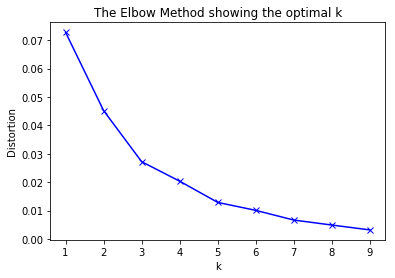

In [51]:
Ks = 10
distortions = []

hcm_cafe_clustering = hcm_grouped_cafe.drop('District', 1)

for k in range(1, Ks):

    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(hcm_cafe_clustering)

    # find the distortion w.r.t each k
    distortions.append(
        sum(np.min(cdist(hcm_cafe_clustering, kmeans.cluster_centers_, 'euclidean'), axis=1))
        / hcm_cafe_clustering.shape[0]
    )

plt.plot(range(1, Ks), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [52]:
nclusters = 3
kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(hcm_cafe_clustering)

Let's create a new dataframe look like hcm_grouped_cafe but contains the cluster labels for each district.

In [53]:
df_cafe = hcm_grouped_cafe.copy()
df_cafe["Cluster Labels"] = kmeans.labels_

# add two columns Latitude and Logitude into cafe_merged
df_cafe = df_cafe.join(df.set_index("District"), on="District")

# sort the table by cluster labels
df_cafe.sort_values(["Cluster Labels"], inplace=True)

# Drop some unnecessary columns
df_cafe = df_cafe.drop(["Subdistrict", "Area (km2)"], axis=1)


df_cafe

,District,Café,Cluster Labels,Population 2015,Density (pop/m2),Average Housing Price (1M VND),Latitude,Longitude
18,Thu Duc,0.300000,0,528413,10619.232,64.7 /m2,10.852588,106.755838
14,Go Vap,0.233333,0,634146,32124.924,99.5 /m2,10.840150,106.671083
2,11,0.228571,0,230596,44863.035,167 /m2,10.764208,106.643282
3,12,0.333333,0,510326,9668.928,47.4 /m2,10.867233,106.653930
12,Binh Tan,0.250000,0,686474,13229.408,63.2 /m2,10.749809,106.605664
11,9,0.000000,1,290620,2549.298,48.2 /m2,10.824543,106.818015
10,8,0.000000,1,431969,22521.846,67 /m2,10.740400,106.665843
0,1,0.060000,1,193632,25049.418,430 /m2,10.774540,106.699184
6,4,0.057143,1,186727,44671.531,85.7 /m2,10.759243,106.704890
7,5,0.060000,1,178615,41830.211,255 /m2,10.756129,106.670376


## Visualize the clusters on map

In [54]:
map_clusters = folium.Map(location=[hcm_lat, hcm_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(nclusters)
ys = [i+x+(i*x)**2 for i in range(nclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        df_cafe['Latitude'], 
        df_cafe['Longitude'], 
        df_cafe['District'], 
        df_cafe['Cluster Labels']
):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Conclusion

From all above results, we conclude that, the best place for us to set up a new café is in district 4 because there are a lot of people living there (high density), there are not many already-working café (cluster 0) and the average housing price is low.